In [ ]:

import torch
import os
from torch.utils.data import RandomSampler
import torch.nn.functional as F
import time
import torch.nn as nn
import datetime

In [3]:
import import_ipynb
import data_processing
import custom_model
from evaluate import evaluate_epoch, evaluate_final

<string>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead


Image batch shape: torch.Size([16, 3, 128, 128])
Label batch shape: torch.Size([16])
First batch of images: tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],


In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
NUM_EPOCHS = 30

model = custom_model.resnet18(num_classes=10)

model = model.to(DEVICE)

#原先这里选用SGD训练，但是效果很差，换成Adam优化就好了
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
valid_loader = data_processing.test_loader
test_loader = data_processing.test_loader
train_loader = data_processing.train_loader


In [7]:
for images, labels in test_loader:
    print("Labels:", labels)
    print("Unique values in labels:", labels.unique())
    break  # 只查看一个批次的数据

Labels: tensor([0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1])
Unique values in labels: tensor([0, 1])


Epoch: 001/030 | Batch 0000/1248 | Cost: 2.3067
Epoch: 001/030 | Batch 0500/1248 | Cost: 0.3990
Epoch: 001/030 | Batch 1000/1248 | Cost: 0.2748
Evaluation at epoch : 001/030
{
    Loss: train = 0.2648; validation = 0.2701
    Accuracy: train = 89.09%; validation = 89.15%
    Precision: train = 0.85; validation = 0.87
    Recall: train = 0.88; validation = 0.87
    F1 Score: train = 0.86; validation = 0.87
}
001/030 time elapsed: 3.31 min
Epoch: 002/030 | Batch 0000/1248 | Cost: 0.2847
Epoch: 002/030 | Batch 0500/1248 | Cost: 0.1611
Epoch: 002/030 | Batch 1000/1248 | Cost: 0.2338
Evaluation at epoch : 002/030
{
    Loss: train = 0.2463; validation = 0.2481
    Accuracy: train = 90.83%; validation = 90.54%
    Precision: train = 0.94; validation = 0.95
    Recall: train = 0.82; validation = 0.82
    F1 Score: train = 0.87; validation = 0.88
}
002/030 time elapsed: 9.06 min
Epoch: 003/030 | Batch 0000/1248 | Cost: 0.0417
Epoch: 003/030 | Batch 0500/1248 | Cost: 0.1912
Epoch: 003/030 | Bat

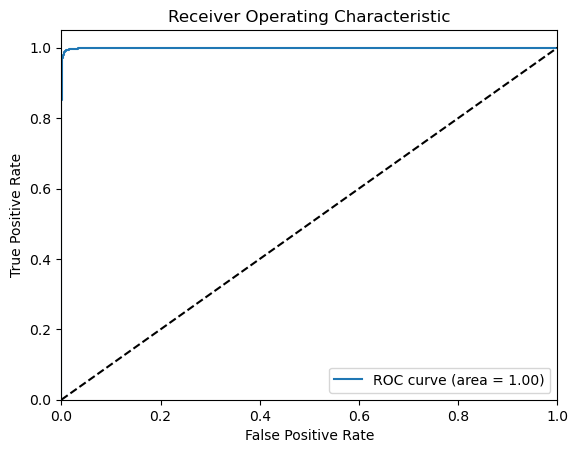

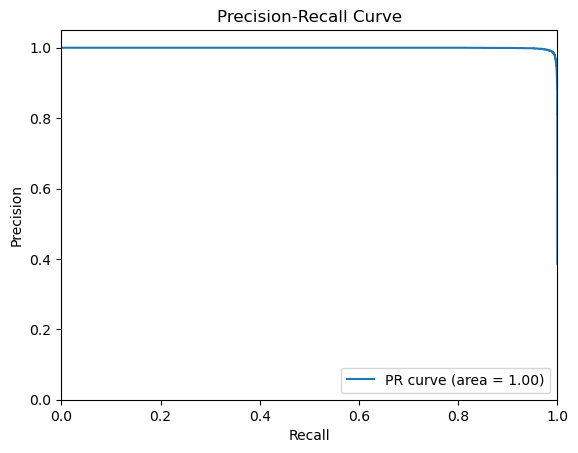

Total training time: 130.22 min


In [ ]:
# 损失函数
criterion = nn.CrossEntropyLoss()

# 初始化列表用于存储评估指标
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

# 记录开始时间
start_time = time.time()

# 训练和评估
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(features)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        
        cost = criterion(outputs, targets)
        cost.backward()
        optimizer.step()
        
        train_loss += cost.item()
        
        if not batch_idx % 500:
            print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                  f'Batch {batch_idx:04d}/{len(train_loader):04d} | ' 
                  f'Cost: {cost:.4f}')
    
    # 计算平均训练损失
    avg_train_loss = train_loss / len(train_loader)

    # 评估当前epoch模型
    model.eval()
    with torch.set_grad_enabled(False):
        train_metrics, valid_metrics = evaluate_epoch(model, train_loader, valid_loader, DEVICE, epoch, NUM_EPOCHS, criterion, pos_label=1)
        
        train_acc_lst.append(train_metrics['accuracy'])
        valid_acc_lst.append(valid_metrics['accuracy'])
        train_loss_lst.append(avg_train_loss)
        valid_loss_lst.append(valid_metrics['loss'])
    
    # 输出当前epoch训练用时
    elapsed = (time.time() - start_time) / 60
    print(f'{epoch+1:03d}/{NUM_EPOCHS:03d} time elapsed: {elapsed:.2f} min')

# 评估整个模型
evaluate_final(model, train_loader, DEVICE, pos_label=1)

# 输出总训练时间
elapsed = (time.time() - start_time)/60
print(f'Total training time: {elapsed:.2f} min')

# 获取当前时间并格式化为字符串
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M')

# 训练完成，保存模型，并附带时间戳
torch.save(model.state_dict(), f'../model/model_{timestamp}.pth')